In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import torch
print(torch.__version__)

import gzip
import pickle

1.6.0


<img src="../img/intro-paranal.jpg">

# Estrellas variables

- Estrellas cuyo brillo varía en el tiempo
- Existen distintas razones que explican estas variaciones

## Estrellas variables pulsantes
- Estrellas que pulsan radialmente
- Se expanden y contraen de forma regular y periódica
- Ejemplos: RR Lyrae y Cefeidas

<center>
<a href="https://www.youtube.com/watch?v=sXJBrRmHPj8">
    <img src="https://media.giphy.com/media/QP4taxvfVmVEI/giphy.gif" width="400">
</a>
</center>

## Sistemas eclipsantes binarios

- Sistemas de dos estrellas
- Su plano de rotación está alineado con la Tierra
- Desde nuestro punto de vista, vemos como el brillo crece y decrece por los eclipses mutuos
<center>
<table>
    <tr><td>
        <a href="http://www.physast.uga.edu/~rls/astro1020/ch16/ovhd.html">
            <img src="../img/intro-eb.gif" width="300">
        </a>
    </td>
    <td>
        <a href="https://en.wikipedia.org/wiki/File:Algol_AB_movie_imaged_with_the_CHARA_interferometer_-_labeled.gif">
            <img src="https://media.giphy.com/media/aYb0Ob2GHJ280/giphy.gif" width="300">
        </a>
    </td></tr>
</table>
</center>

# ¿Por qué es interesante estudiar estos objetos?


Con RR Lyrae y Cefeidas se pueden calcular distancias y hacer mapas de nuestro vecindario galáctico

<table>
    <tr><td>   
        <img src="../img/period-luminosity-relation.gif" width="400">
    </td><td>
        <img src="../img/intro-milky-way.jpg" width="400">
    </td></tr>
</table>


La variabilidad nos da información de su física, podemos entender mejor los procesos estelares

<center>
<a href="http://www.atnf.csiro.au/outreach/education/senior/astrophysics/variable_types.html">
    <img src="../img/variable-star-classification.gif" width="400">
</a>
</center>


# Curvas de luz

- Son series de tiempo de flujo o brillo estelar en una cierta frecuencia (banda de paso)
- Este brillo "aparente" se estima usando **Fotometría**
- Las curvas de luz son fundamentales para estudiar las estrellas variables

<table><tr><td>
    <img src="../img/intro-vista.png" width="250">
</td><td>
    <img src="../img/intro-sources.png" width="300">
</td></tr></table>

<center>
    <img src="../img/intro-sources-time.png" width="600">
</center>

# Inspeccionando curvas de luz

Tipicamente la curva de luz es un archivo de texto con tres columnas (mínimo)
- **Modified Julian Data (MJD):** Tiempo en días
- **Magnitude:** Brillo relativo en escala logarítima (más magnitude significa menos brillante)
- **Error:** Estimación del error fotométrico de la magnitud, se interpreta como una desviación estándar

<IPython.core.display.Javascript object>


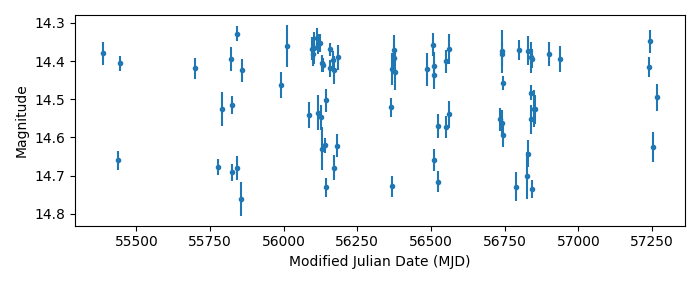

In [2]:
with gzip.open("../data/lc_data.pgz", mode="r") as f:
    lc_data = pickle.load(f)
    
lc_periods = pickle.load(open("../data/lc_periods.pkl", "rb"))

fig, ax = plt.subplots(figsize=(7, 3), tight_layout=True)
mjd, mag, err = lc_data[6].T
ax.errorbar(mjd, mag, err, fmt='.')
ax.invert_yaxis(); 
ax.set_xlabel('Modified Julian Date (MJD)\n ')
ax.set_ylabel('Magnitude');

Podemos notar que

- El muestreo es irregular, existen múltiples "gaps"
- La variance del ruido cambia en el tiempo: Error heterocedastico



# "Doblando una curva"

La curva que acabamos de ver es de una estrella periódica

Podemos estudiar su periodicidad usando la transformación de *epoch folding*

$$
\phi_i = \text{mod}(t_i, P)/P
$$

donde $P$ es el periódo de la curva de luz (debemos conocerlo)

El resultado se conoce como "curva doblada" o diagrama de fase

<IPython.core.display.Javascript object>


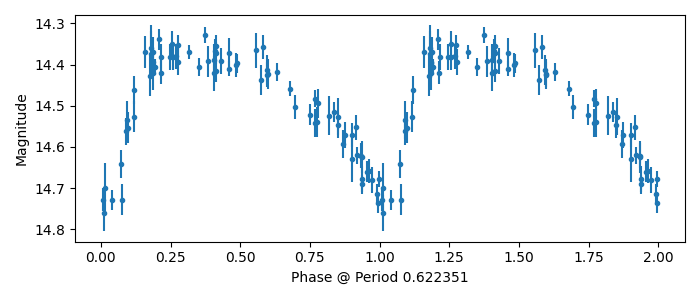

In [3]:
def fold(time, period):
    """
    returns phase = time/period - floor(time/period)
    """
    return np.mod(time, period)/period

idx = 6
mjd, mag, err = lc_data[idx].T
fig, ax = plt.subplots(figsize=(7, 3), tight_layout=True)
phi = fold(mjd, lc_periods[idx])
ax.errorbar(np.hstack((phi, phi+1)), 
            np.hstack((mag, mag)), 
            np.hstack((err, err)), fmt='.')
ax.invert_yaxis(); 
ax.set_ylabel('Magnitude');
ax.set_xlabel('Phase @ Period %0.6f' %(lc_periods[idx]));

¿Qué pasa si no conozco el periódo? ¿Cómo se ve la curva si la doblo con un periódo incorrecto?

<IPython.core.display.Javascript object>


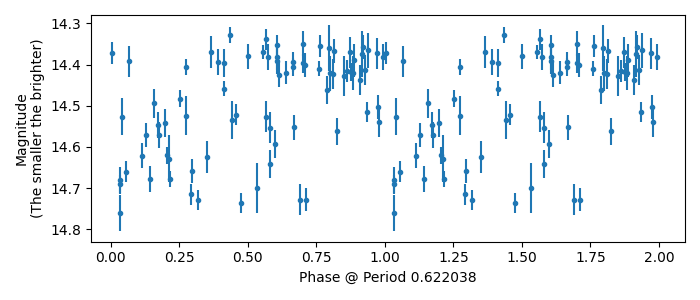

In [4]:
fig, ax = plt.subplots(figsize=(7, 3), tight_layout=True)
period_grid = np.linspace(lc_periods[6]-0.001, lc_periods[6]+0.001, num=100)
phi = fold(mjd, period_grid[0])
line, caps, errorbars = ax.errorbar(np.hstack((phi, phi+1)), 
                                    np.hstack((mag, mag)), 
                                    np.hstack((err, err)), fmt='.')
segs = errorbars[0].get_segments()
ax.invert_yaxis(); 
ax.set_ylabel('Magnitude\n(The smaller the brighter)');

def update(n):
    phi = fold(mjd, period_grid[n])
    for i in range(len(segs)//2):
        segs[i][:, 0] = phi[i]
        segs[i+len(phi)][:, 0] = phi[i]+1

    line.set_xdata(np.hstack((phi, phi+1))) 
    errorbars[0].set_segments(segs)
    ax.set_xlabel('Phase @ Period %0.6f' %(period_grid[n]))

anim = animation.FuncAnimation(fig, update, frames=100, interval=100, repeat=False, blit=True)

# Creando una representación regular a partir de curvas dobladas

- Queremos entrenar un modelo de autoencoder sobre las curvas de luz periódicas
- Asumamos que ya tenemos el periódo de cada curva de luz calculado y guardado
- Podemos normalizar e interpolar las curvas dobladas usando una media movil o una regresión con kernel


<IPython.core.display.Javascript object>


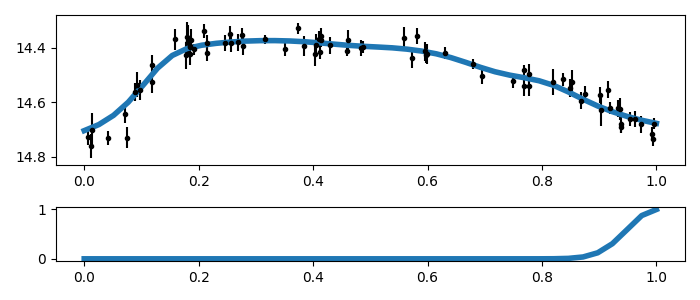

In [5]:
idx = 6
mjd, mag, err = lc_data[idx].T
phi = fold(mjd, lc_periods[idx]) 
w = 1.0/err**2
phi_interp = np.linspace(0, 1, num=40)

fig = plt.figure(figsize=(7, 3), tight_layout=True)
ax1 = plt.subplot2grid((3,1), (0,0), rowspan=2, fig=fig)
ax1.errorbar(phi, mag, err, fmt='.', c='k'); ax1.invert_yaxis();
l1 = ax1.plot(phi_interp, [np.amax(mag)]*len(phi_interp), lw=4)

ax2 = plt.subplot2grid((3,1), (2,0), rowspan=1, fig=fig)
l2 = ax2.plot(phi_interp, np.exp(-0.5*phi_interp**2/0.1**2), lw=4)
mag_interp = np.ones_like(phi_interp)*np.amax(mag)

def update(idx):
    gt = np.exp(-0.5*(phi_interp[idx]-phi)**2/0.05**2)
    mag_interp[idx] = np.sum(w*gt*mag)/np.sum(w*gt)
    l1[0].set_ydata(mag_interp)
    l2[0].set_ydata(np.exp(-0.5*(phi_interp-phi_interp[idx])**2/0.05**2))
anim = animation.FuncAnimation(fig, update, frames=40, interval=100, repeat=False, blit=True)

# Dataset

- Usaremos 5000 curvas de luz del proyecto VVV
- Las primeras 4950 son curvas de luz del bulbo galáctico sin etiqueta
- Las últimas 50 son curvas de luz periódicas de RR Lyrae

La función `featurize_lc` realiza la interpolación, normalización y traslación de las curvas de luz (revisar en clases)

<IPython.core.display.Javascript object>


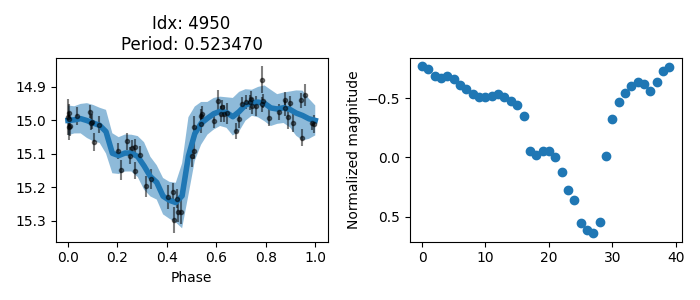

Button(description='Next', style=ButtonStyle())

In [6]:
from utils import featurize_lc, defeaturize_lc
from IPython.display import display
from ipywidgets import Button

phi_interp = np.linspace(0, 1, num=40)
features = np.zeros(shape=(len(lc_data), len(phi_interp)))
weights = np.zeros(shape=(len(lc_data), len(phi_interp)))
norm = np.zeros(shape=(len(lc_data), 3))
for i in range(len(lc_data)):
    features[i, :], weights[i, :], norm[i, :] = featurize_lc(lc_data[i], lc_periods[i], phi_interp)
    
next_button = Button(description="Next")
idx = 4950
fig, ax = plt.subplots(1, 2, figsize=(7, 3), tight_layout=True)

def plot_features(idx):
    ax[0].cla();
    ax[1].cla()
    ax[0].set_title("Idx: %d\nPeriod: %0.6f" %(idx, lc_periods[idx]))
    mag, err = defeaturize_lc(features[idx, :], weights[idx, :], norm[idx, :])
    ax[0].plot(phi_interp, mag, lw=4)
    ax[0].fill_between(phi_interp, (mag-err), (mag+err), alpha=0.5)
    ax[0].set_xlabel('Phase'); 
    ax[1].set_ylabel('Normalized magnitude');
    mjd, mag, err = lc_data[idx][:, 0], lc_data[idx][:, 1], lc_data[idx][:, 2]
    phi = fold(mjd, lc_periods[idx])
    ax[0].errorbar(phi, mag, err, fmt='.', c='k', alpha=0.5, label='data'); 
    ax[0].invert_yaxis()
    ax[1].plot(features[idx, :], 'o')
    ax[1].invert_yaxis()

def on_nbutton_clicked(b):
    global idx
    idx += 1
    plot_features(idx)
                
next_button.on_click(on_nbutton_clicked)
plot_features(idx)
display(next_button)

Dataset y dataloaders para pytorch

In [322]:
from torch.utils.data import TensorDataset, DataLoader, SubsetRandomSampler

lc_dataset = TensorDataset(torch.from_numpy(features.astype('float32')))
                           #torch.from_numpy(weights.astype('float32')))
                           #torch.from_numpy(lc_periods.astype('float32')))



np.random.seed(1234) 

# Generate data loaders
P = np.random.permutation(5000)
train_loader = DataLoader(dataset=lc_dataset, batch_size=32, 
                          sampler=SubsetRandomSampler(P[:4000]))
valid_loader = DataLoader(dataset=lc_dataset, batch_size=128, 
                          sampler=SubsetRandomSampler(P[4000:]))


# Tarea: Entrenando un autoencoder

- Entrene un autoencoder variacional para comprimir y visualizar las curvas de luz. Proponga una arquitectura y distribuciones adecuadas para el encoder y decoder. Programe el modelo y la función de costo
- Genere una visualización 2D del espacio latente, como un scatter plot con un punto por curva de luz. Cada punto debe estar centrado en $\mu$ y con barras de error $\sigma$. Las curvas no etiquetadas de color azul y las curvas RR Lyra en color rojo. Realice una visualización interactiva que muestre el dato original y su reconstrucción cuando se selecciona en el espacio latente (ver ejemplo lección 1)
- Obtenga y visualice el espacio latente interpolado. ¿En que parte del espacio latente se ubican las RR Lyrae? Genere 10 realizaciones de curvas de luz de RR Lyrae según la ubicación que decidió en el espacio latente


##### Abajo hay un resumen de lo implementado y las respuestas

In [323]:
from torch import nn
import numpy as np
import torch.nn.functional as F

class VAE_Linear(nn.Module):
    ## n_hidden debe ser una lista
    def __init__(self, n_in, n_hidden, activation, sigma):
        super(VAE_Linear, self).__init__()
        self.SIGMA = sigma
        
        ## codificador
        self.cod_input = nn.Linear(n_in, n_hidden[0])
        self.cod_hiddens = nn.ModuleList([nn.Linear(n_hidden[i], n_hidden[i+1]) for i in range(len(n_hidden)-1)])
        self.cod_out1 = nn.Linear(n_hidden[-1], 2)
        self.cod_out2 = nn.Linear(n_hidden[-1], 2)
        
        ## decodificador
        self.dec_input = nn.Linear(2, n_hidden[-1])
        self.dec_hiddens = nn.ModuleList([nn.Linear(n_hidden[-i-1], n_hidden[-i-2]) for i in range(len(n_hidden)-1)])
        self.dec_out = nn.Linear(n_hidden[0], n_in)
        
        
        self.act = activation
        
    
    def encoder(self, x):
        x = self.act(self.cod_input(x))
        for capa in self.cod_hiddens:
            x = self.act(capa(x))            
        x1 = self.cod_out1(x)
        x2 = self.cod_out2(x)
        return x1, x2
    
    def decoder(self, z):
        z = self.act(self.dec_input(z))
        for capa in self.dec_hiddens:
            z = self.act(capa(z))
        x_hat = self.dec_out(z) ## lleva activacion?
        return x_hat
    
    def forward(self, x):
        mu, sigma = self.encoder(x)
        z = mu + sigma.exp() * torch.normal(mean=torch.tensor([0., 0.]), std=torch.tensor([1.0, 1.0]))
        x_hat = self.decoder(z)
        
        #stds = torch.ones(x_hat.shape)*self.SIGMA

        return x_hat

In [324]:
def lossy(model, batch, SIGMA, L):
    #new = torch.cat((batch[0], batch[1]),dim=1)
    new = batch[0]
    mu, sigma = model.encoder(new)
    suma = torch.zeros(batch[0].shape[0])
    for i in range(L):
        z = mu + sigma.exp() * torch.normal(mean=torch.tensor([0., 0.]), std=torch.tensor([1.0, 1.0]))

        x_hat = model.decoder(z)        
        suma += (new-(x_hat)).norm(dim=1)
    suma = suma.sum()
    loss1 = 1/(2*SIGMA*SIGMA)*suma
    
    K = torch.ones(len(batch[0]))*mu.shape[1]
    loss2 = 0.5 * (K + (2*sigma - sigma.exp().pow(2) - mu.pow(2)).sum(axis=1)).sum()
    return (loss1-loss2)/len(batch[0])

In [325]:
ARCH = [30,20,10]
FILENAME = 'best-so-farLINEAR'+str(ARCH)+'.pt'
EPOCHS = 100
SIGMA = 0.5
#N_IN = features[0].shape[0]+weights[0].shape[0]
N_IN = features[0].shape[0]
L = 20

<IPython.core.display.Javascript object>


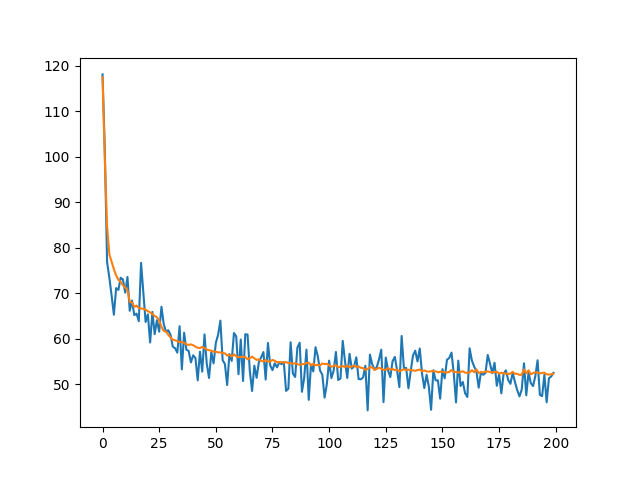

In [326]:
import matplotlib.pyplot as plt
losses = []
validations = []

fig, ax = plt.subplots(1,1)
line1, = ax.plot(losses, label="training loss");
line2, = ax.plot(validations, label = "validation loss");
ax.legend()

In [327]:
from tqdm import tqdm


model = VAE_Linear(N_IN, ARCH, F.relu, SIGMA)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
best_loss = 99999999

bar = tqdm(range(EPOCHS))
for epoch in bar:
    
    for i, local_batch in enumerate(train_loader):
        #print(local_batch[0].shape)
        #print(mu.sum(axis=1))
        loss = lossy(model, local_batch, SIGMA, L)
        if i%64==0:
            bar.set_description("Processing %f" % loss.item())
            bar.refresh() # to show immediately the update
            if loss < best_loss:
                best_loss = loss
                torch.save(model.state_dict(), FILENAME) 
            with torch.no_grad():
                valloss = 0
                k = 0
                for i, vbatch in enumerate(valid_loader):
                    valloss += lossy(model, vbatch, SIGMA, L)
                    k += 1
                valloss /= k
                
            validations.append(valloss)
            losses.append(loss)
            ax.cla()
            ax.plot(losses);
            ax.plot(validations);
            fig.canvas.draw()
            
    # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
print("Best loss: %f" % best_loss)

Processing 52.558903: 100%|██████████| 100/100 [02:03<00:00,  1.23s/it]

Best loss: 44.305103


<IPython.core.display.Javascript object>


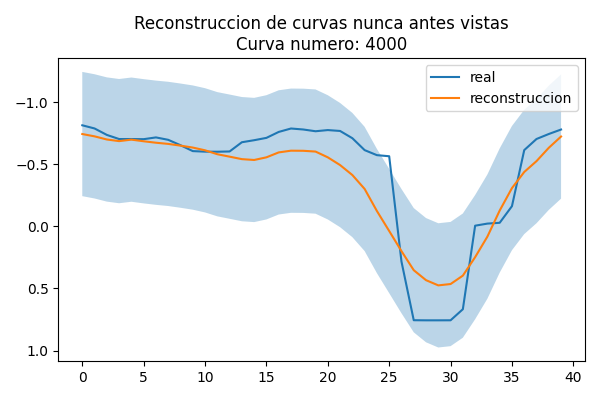

Button(description='Next', style=ButtonStyle())

In [332]:
import random

FILENAME = 'best-so-farLINEAR'+str(ARCH)+'.pt'

#N_IN = features[0].shape[0]+weights[0].shape[0]
N_IN = features[0].shape[0]

model = VAE_Linear(N_IN, ARCH, F.relu, SIGMA)
model.load_state_dict(torch.load(FILENAME))


idx = 4000
#x = torch.from_numpy(np.concatenate((features[idx], weights[idx]), axis=0).astype('float32'))
x = torch.from_numpy(features[idx].astype('float32'))

xhat = model(x)
nextbutton = Button(description="Next")
fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=True)

def plot_features2(idx, x, xhat):
    ax.cla();
    ax.invert_yaxis()
    ax.set_title("Reconstruccion de curvas nunca antes vistas\nCurva numero: %d" % (idx))
    ax.plot(x[:40], label="real")
    xhat = xhat.detach().numpy()[:40]
    ax.plot(xhat, label="reconstruccion")
    ax.fill_between(np.arange(40), (xhat+SIGMA), (xhat-SIGMA), alpha=0.3)

    ax.legend()
    
def on_nbutton_clicked2(b):
    global idx
    idx = random.randrange(1000)+4000
    
    x = torch.from_numpy(features[idx].astype('float32'))
    
    xhat = model(x)
    plot_features2(idx, x, xhat)
                
nextbutton.on_click(on_nbutton_clicked2)
plot_features2(idx, x, xhat)
display(nextbutton)



<IPython.core.display.Javascript object>


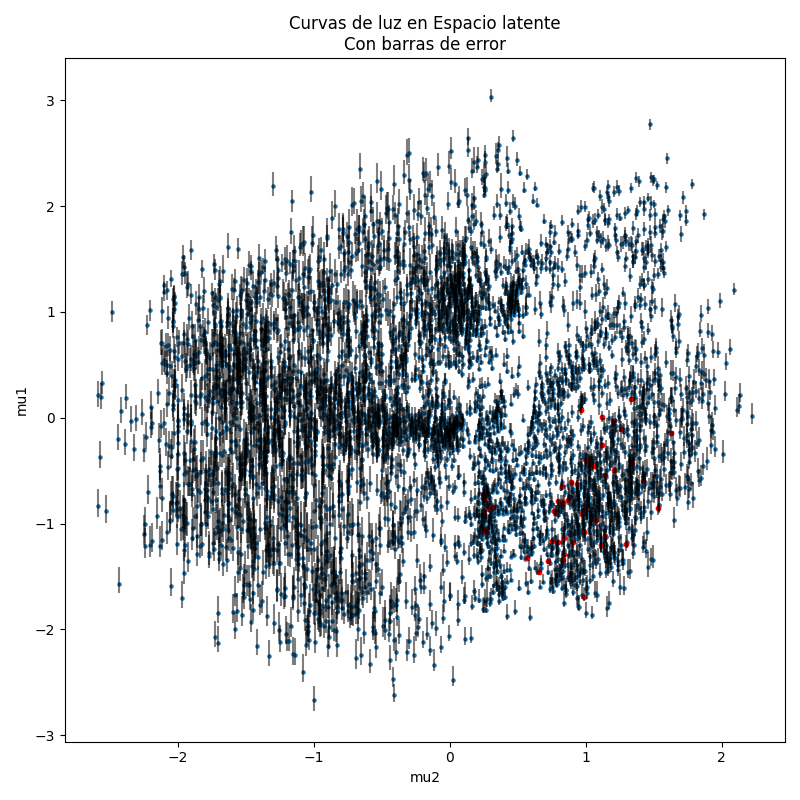

Text(0, 0.5, 'mu1')

In [340]:
fig, ax2 = plt.subplots(1, 1, figsize=(8, 8), tight_layout=True)
#mu, sigma = model.encoder(torch.from_numpy(np.concatenate((features, weights), axis=1).astype('float32')))
x = torch.from_numpy(features.astype('float32'))
mu, sigma = model.encoder(torch.from_numpy(features.astype('float32')))

mu = mu.detach().numpy()
sigma = sigma.detach().numpy()

otras = mu[:4950]
rr = mu[4950:]

ax2.errorbar(otras[:,1], otras[:,0], (np.exp(sigma[:4950][:,1]), np.exp(sigma[:4950][:,0])), fmt=' ', c='k', alpha=0.25, label='data'); 
ax2.errorbar(rr[:,1], rr[:,0], (np.exp(sigma[4950:][:,1]), np.exp(sigma[4950:][:,0])), fmt=' ', c='k', alpha=0.25, label='data'); 

ax2.scatter(otras[:,1], otras[:,0], s=5)
ax2.scatter(rr[:,1], rr[:,0], s=10, c='r');
ax2.title.set_text("Curvas de luz en Espacio latente\nCon barras de error")
ax2.set_xlabel("mu2")
ax2.set_ylabel("mu1")


<IPython.core.display.Javascript object>


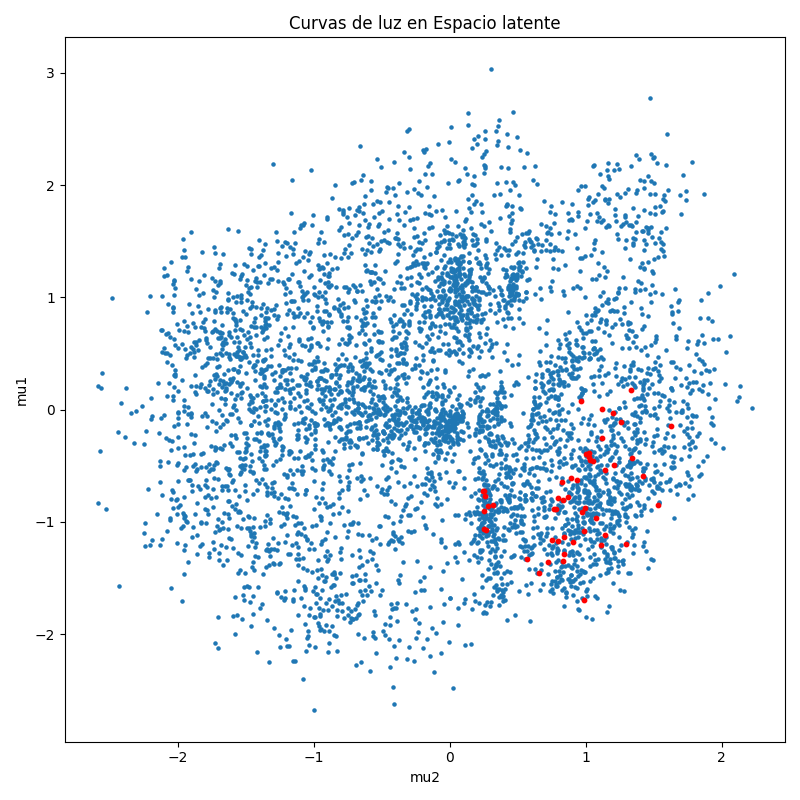

Text(0, 0.5, 'mu1')

In [339]:
fig, ax2 = plt.subplots(1, 1, figsize=(8, 8), tight_layout=True)
#mu, sigma = model.encoder(torch.from_numpy(np.concatenate((features, weights), axis=1).astype('float32')))
x = torch.from_numpy(features.astype('float32'))
mu, sigma = model.encoder(torch.from_numpy(features.astype('float32')))

mu = mu.detach().numpy()
sigma = sigma.detach().numpy()

otras = mu[:4950]
rr = mu[4950:]

ax2.scatter(otras[:,1], otras[:,0], s=5)
ax2.scatter(rr[:,1], rr[:,0], s=10, c='r');
ax2.title.set_text("Curvas de luz en Espacio latente")
ax2.set_xlabel("mu2")
ax2.set_ylabel("mu1")

<IPython.core.display.Javascript object>


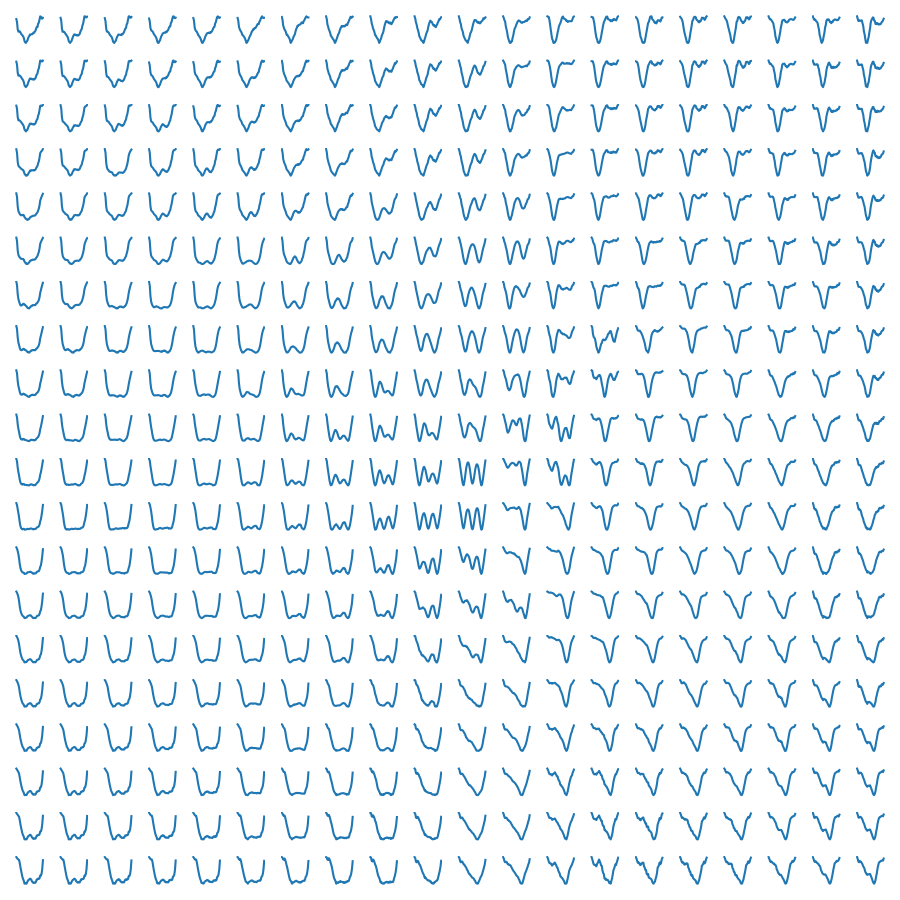

In [341]:
mu_ylims = [mu[:,0].min(), mu[:,0].max()]
mu_xlims = [mu[:,1].min(), mu[:,1].max()]
sigma_ylims = [sigma[:,0].min(), sigma[:,0].max()]
sigma_xlims = [sigma[:,1].min(), sigma[:,1].max()]

M = 20
mu_xlin = np.linspace(mu_xlims[0], mu_xlims[1], M)
mu_ylin = np.linspace(mu_ylims[1], mu_ylims[0], M)
sigma_xlin = np.linspace(sigma_xlims[0], sigma_xlims[1], M)
sigma_ylin = np.linspace(sigma_ylims[1], sigma_ylims[0], M)

fig, ax = plt.subplots(M, M, figsize=(9, 9), tight_layout=True)

for i in range(M):
    for j in range(M):
        ax[i, j].axis('off')
        z = torch.tensor([mu_ylin[i], mu_xlin[j]]) + torch.tensor([sigma_ylin[i], sigma_xlin[j]]).exp() * torch.normal(mean=torch.tensor([0., 0.]), std=torch.tensor([1.0, 1.0]))
        ax[i, j].invert_yaxis()
        ax[i, j].plot(model.decoder(z.float()).detach().numpy())

##### Las RR Lyrae se ubican en la zona inferior-derecha (4to cuadrante)

/home/newt/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


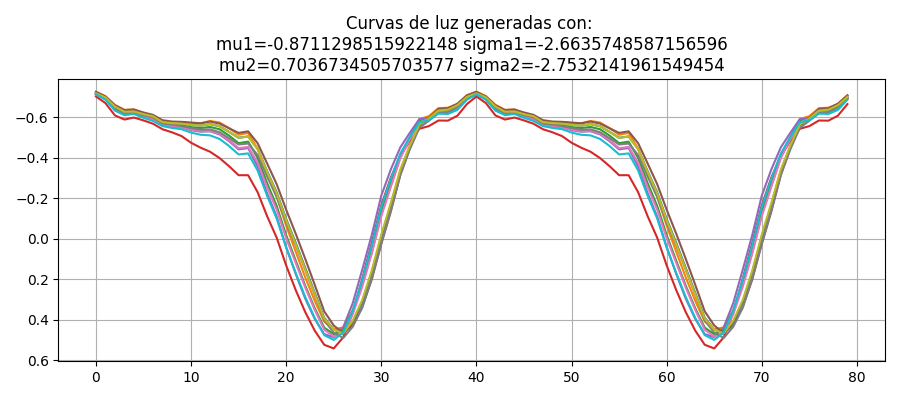

In [342]:
fig, ax = plt.subplots(tight_layout=True, figsize=(9,4))
ax.invert_yaxis()
ax.grid()
ax.title.set_text("Curvas de luz generadas con: \nmu1="+str(mu_ylin[13]) + " sigma1=" + str(sigma_ylin[13]) +"\nmu2="+str(mu_xlin[13]) + " sigma2=" + str(sigma_xlin[13]))

for i in range(10):
    z = torch.tensor([mu_ylin[13], mu_xlin[13]]) + torch.tensor([sigma_ylin[13], sigma_xlin[13]]).exp() * torch.normal(mean=torch.tensor([0., 0.]), std=torch.tensor([1.0, 1.0]))
    res = model.decoder((z.float())).detach().numpy()
    ax.plot(np.hstack((res,res)))

## Resumen de lo anterior

Tanto $z$ como $\hat{x}$ se modelaron con distribucion normal.

La arquitectura propuesta consta solo de capas fully connected de neuronas (MLP) con 40 en la entrada, seguido 3 capas con 30, 20 y 10 neuronas, respectivamente. La salida son 2 capas independientes de 2 neuronas cada una. Una cabeza entrega las medias $\mu$ de la normal que genera $z$, la otra entrega el logaritmo de las desviacion estandar $\sigma$. 
La parte del decoder esta compuesto por las mismas capas en orden inverso, _i.e._ 2-10-20-30-40 neuronas en cada capa. 
Como optimizador se uso ADAM. y para la funcion de activacion se uso la funcion ReLU.
Para este modelo solo se consideraron los features de cada curva de luz.
El VAE solo intenta reconstruir los 40 features de entrada.

El modelo se entreno durante $100$ epocas, con $\hat{\sigma}^2 = 0.5$, tamano de batch igual a $32$ y $L=20$, es decir, 20 muestras de $z$ al momento de calcular el error.


## Intentando usar redes convolucionales y todos los datos 
## \**caution is advised**

Esta seccion repite todo lo anterior pero con algunos cambios en el modelo. 
Para comenzar la entrada de la red ahora incluye todos los datos disponibles de una curva de luz; sus features, weights (errores) y el periodo. Los features y weights (al tener el mismo tamano) se agruparon en verticalmente en un tensor (quedando como (batch, 2, 40))

La arquitectura de la red tambien cambio, ahora se utiliza 2 capas convolucionales de 1D al comienzo del "encoder", con kernels de tamano $5\times5$ y $3\times3$, respectivamente.

La salida de la ultima convolucion se aplano para ingresar como input a una serie de capas _fully connected_ con $512+1$, $32$ y $2$ neuronas cada una. La ultima capa (de 2 neuronas) representa la salida del "encoder" igual al caso anterior. La primera capa tiene $512+1$ neuronas ya que se le agrega el periodo a la salida de las capas convolucionales.

Como "decoder" se utilizan capas con $2, 10, 30, 70$ y $80$ neuronas cada una, en orden. 

En este caso, el VAE intenta reconstruir los features y weights, por lo que solo estos son utilizados para calcular la loss.

El modelo se entreno durante $50$ epocas, con $\hat{\sigma}^2 = 0.5$, tamano de batch igual a $32$ y $L=20$, es decir, 20 muestras de $z$ al momento de calcular el error.

In [40]:
from torch.utils.data import TensorDataset, DataLoader, SubsetRandomSampler

lc_dataset = TensorDataset(torch.from_numpy(features.astype('float32')),
                           torch.from_numpy(weights.astype('float32')),
                           torch.from_numpy(lc_periods.astype('float32')))



np.random.seed(1234) 

# Generate data loaders
P = np.random.permutation(5000)
train_loader = DataLoader(dataset=lc_dataset, batch_size=32, 
                          sampler=SubsetRandomSampler(P[:4000]))
valid_loader = DataLoader(dataset=lc_dataset, batch_size=128, 
                          sampler=SubsetRandomSampler(P[4000:]))

 los datos deben estan en forma [32, 2, 40] = [batch, channel, length] para la capa conv

In [41]:
from torch import nn
import numpy as np
import torch.nn.functional as F

class VAE_Conv(nn.Module):
    ## n_hidden debe ser una lista
    def __init__(self, channels_in, n_hidden_cod, n_hidden_dec, conv_channels, activation, sigma):
        super(VAE_Conv, self).__init__()
        self.SIGMA = sigma
    
        ## codificador
        self.cod_conv1 = nn.Conv1d(channels_in, conv_channels[0], 5)
        self.cod_conv2 = nn.Conv1d(conv_channels[0], conv_channels[1], 3)
        
        self.cod_hidden1 = nn.Linear(conv_channels[1]*34+1, n_hidden_cod[0])
        self.cod_hiddens = nn.ModuleList([nn.Linear(n_hidden_cod[i], n_hidden_cod[i+1]) for i in range(len(n_hidden_cod)-1)])
        self.cod_out1 = nn.Linear(n_hidden_cod[-1], 2)
        self.cod_out2 = nn.Linear(n_hidden_cod[-1], 2)
        
        ## decodificador
        self.dec_input = nn.Linear(2, n_hidden_dec[-1])
        self.dec_hiddens = nn.ModuleList([nn.Linear(n_hidden_dec[-i-1], n_hidden_dec[-i-2]) for i in range(len(n_hidden_dec)-1)])
        self.dec_out = nn.Linear(n_hidden_dec[0], 80)

        self.act = activation
        
    def prepareX(self, x):
        period = x[2]
        aux = torch.ones((len(x[0]),2,40))
        aux[:,0,:] = x[0]
        aux[:,1,:] = x[1]
        return aux, period.unsqueeze(1)
    
    def encoder(self, x):
        x, period = self.prepareX(x)

        x = self.act(self.cod_conv1(x))
        x = self.act(self.cod_conv2(x))
        x = x.view(x.shape[0], -1)
        x = torch.cat((x, period), dim=1)
        #falta anadir periodo
        
        x = self.act(self.cod_hidden1(x))
        
        for capa in self.cod_hiddens:
            x = self.act(capa(x))     
            
        x1 = self.cod_out1(x)
        x2 = self.cod_out2(x)
        return x1, x2
    
    def decoder(self, z):
        z = self.act(self.dec_input(z))
        for capa in self.dec_hiddens:
            z = self.act(capa(z))
        x_hat = self.dec_out(z) ## lleva activacion?
        return x_hat
    
    def forward(self, x):
        mu, sigma = self.encoder(x)
        z = mu + sigma.exp() * torch.normal(mean=torch.tensor([0., 0.]), std=torch.tensor([1.0, 1.0]))
        x_hat = self.decoder(z)
        
        #stds = torch.ones(x_hat.shape)*self.SIGMA

        return x_hat
    
#model = VAE_Conv(2, COD_ARCH, DEC_ARCH, (16, 32), F.relu, SIGMA)
#for i, local_batch in enumerate(train_loader):
#    loss = lossy(model, local_batch, SIGMA, L)

In [42]:
def lossy(model, batch, SIGMA, L):
    #new = torch.cat((batch[0], batch[1]),dim=1)
    new = torch.cat((batch[0], batch[1]), dim=1)
    mu, sigma = model.encoder(batch)
    suma = torch.zeros(batch[0].shape[0])
    for i in range(L):
        z = mu + sigma.exp() * torch.normal(mean=torch.tensor([0., 0.]), std=torch.tensor([1.0, 1.0]))
        x_hat = model.decoder(z)
        suma += (new - x_hat).norm(dim=1)
    suma = suma.sum()
    loss1 = 1/(2*SIGMA*SIGMA)*suma
    
    K = torch.ones(len(batch[0]))*mu.shape[1]
    loss2 = 0.5 * (K + (2*sigma - sigma.exp().pow(2) - mu.pow(2)).sum(axis=1)).sum()
    return (loss1-loss2)/len(batch[0])

In [43]:
COD_ARCH = [512, 32]
DEC_ARCH = [70, 30, 10]
FILENAME = 'best-so-farCONV'+str(COD_ARCH)+'.pt'
EPOCHS = 50
SIGMA = 0.5
#N_IN = features[0].shape[0]+weights[0].shape[0]
N_IN = features[0].shape[0]
L = 20

<IPython.core.display.Javascript object>


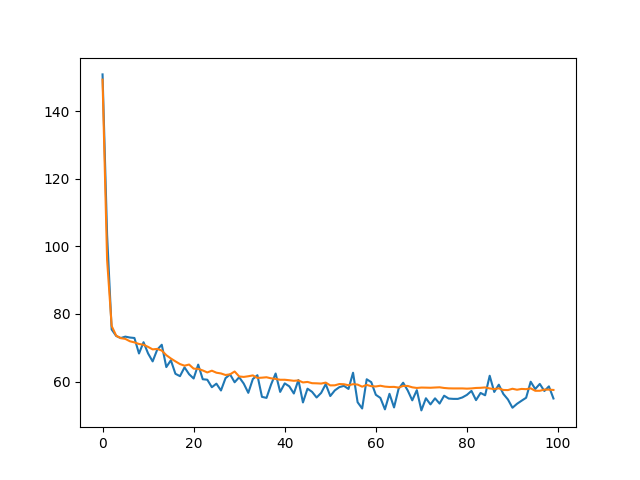

In [44]:
import matplotlib.pyplot as plt
losses = []
validations = []

fig, ax = plt.subplots(1,1)
line1, = ax.plot(losses, label="training loss");
line2, = ax.plot(validations, label = "validation loss");
ax.legend()

In [45]:
from tqdm import tqdm


model = VAE_Conv(2, COD_ARCH, DEC_ARCH, (16, 32), F.relu, SIGMA)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
best_loss = 99999999

bar = tqdm(range(EPOCHS))
for epoch in bar:
    
    for i, local_batch in enumerate(train_loader):
        #print(local_batch[0].shape)
        #print(mu.sum(axis=1))
        loss = lossy(model, local_batch, SIGMA, L)
        if i%64==0:
            bar.set_description("Processing %f" % loss.item())
            bar.refresh() # to show immediately the update
            if loss < best_loss:
                best_loss = loss
                torch.save(model.state_dict(), FILENAME) 
            with torch.no_grad():
                valloss = 0
                k = 0
                for i, vbatch in enumerate(valid_loader):
                    valloss += lossy(model, vbatch, SIGMA, L)
                    k += 1
                valloss /= k
                
            validations.append(valloss)
            losses.append(loss)
            ax.cla()
            ax.plot(losses);
            ax.plot(validations);
            fig.canvas.draw()
            
    # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
print("Best loss: %f" % best_loss)

Processing 54.974640: 100%|██████████| 50/50 [01:30<00:00,  1.81s/it]

Best loss: 51.445839


<IPython.core.display.Javascript object>


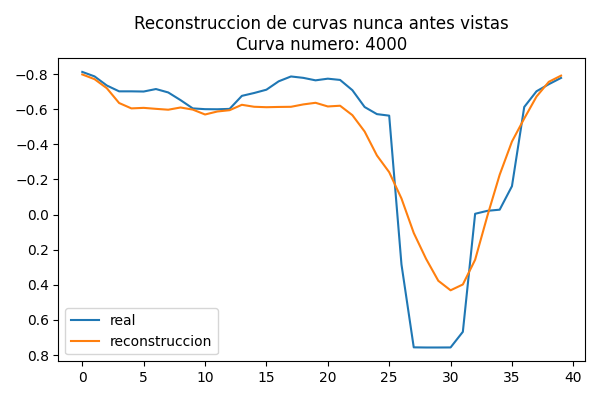

Button(description='Next', style=ButtonStyle())

In [46]:
import random

FILENAME = 'best-so-farCONV'+str(COD_ARCH)+'.pt'

#N_IN = features[0].shape[0]+weights[0].shape[0]
N_IN = features[0].shape[0]

model = VAE_Conv(2, COD_ARCH, DEC_ARCH, (16, 32), F.relu, SIGMA)
model.load_state_dict(torch.load(FILENAME))
idx = 4000


output = DataLoader(dataset=lc_dataset, batch_size=1, 
                          sampler=SubsetRandomSampler([idx]))

for x in output:
    xhat = model(x)

nextbutton = Button(description="Next")
fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=True)

def plot_features2(idx, x, xhat):
    ax.cla();
    ax.invert_yaxis()
    ax.set_title("Reconstruccion de curvas nunca antes vistas\nCurva numero: %d" % (idx))
    ax.plot(x[0][0], label="real")
    xhat = xhat[0].detach().numpy()
    
    ax.plot(xhat[:40], label="reconstruccion")
    #ax.fill_between(np.arange(40), (xhat+SIGMA), (xhat-SIGMA), alpha=0.3)

    ax.legend()
    
def on_nbutton_clicked2(b):
    global idx
    idx = random.randrange(1000)+4000
    
    output = DataLoader(dataset=lc_dataset, batch_size=1, 
                          sampler=SubsetRandomSampler([idx]))
    for x in output:
        xhat = model(x)
    
    plot_features2(idx, x, xhat)
                
nextbutton.on_click(on_nbutton_clicked2)
plot_features2(idx, x, xhat)
display(nextbutton)



<IPython.core.display.Javascript object>


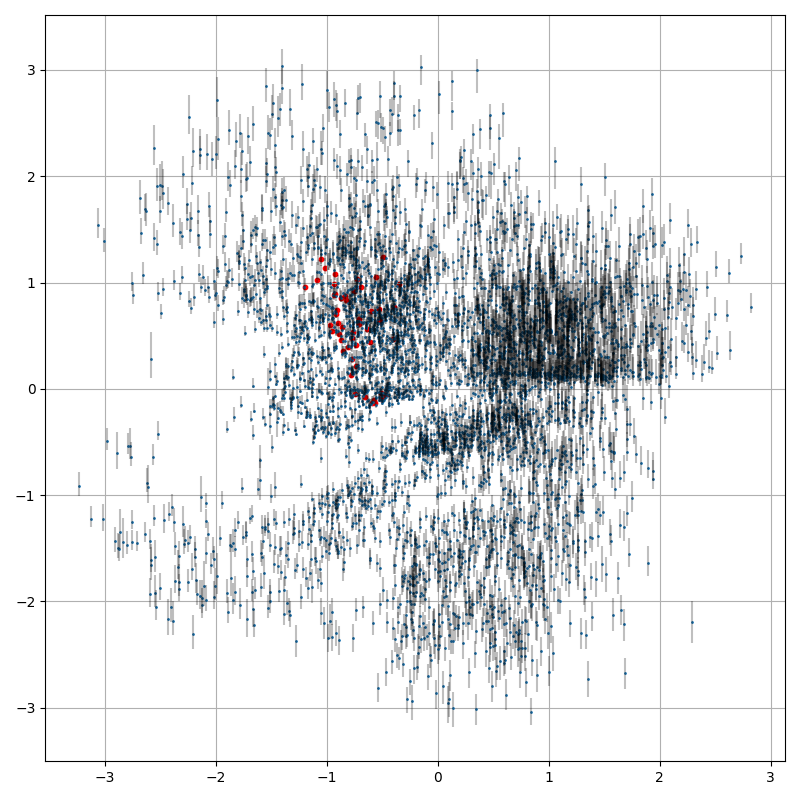

In [47]:
from torch.utils.data import SequentialSampler

fig, ax2 = plt.subplots(1, 1, figsize=(8, 8), tight_layout=True)
#mu, sigma = model.encoder(torch.from_numpy(np.concatenate((features, weights), axis=1).astype('float32')))
#x = torch.from_numpy(features.astype('float32'))

output = DataLoader(dataset=lc_dataset, batch_size=5000, 
                          sampler=SequentialSampler(np.arange(5000)))
for x in output:
    mu, sigma = model.encoder(x)
    


mu = mu.detach().numpy()
sigma = sigma.detach().numpy()

otras = mu[:4950]
rr = mu[4950:]


ax2.grid()
ax2.errorbar(otras[:,1], otras[:,0], (np.exp(sigma[:4950][:,0]),  np.exp(sigma[:4950][:, 1])), fmt=' ', c='k', alpha=0.25, label='data',zorder=3); 
ax2.errorbar(rr[:,1], rr[:,0], (np.exp(sigma[4950:][:,0]),  np.exp(sigma[4950:][:, 1])), fmt=' ', c='k', alpha=0.25, label='data',zorder=3); 

#ax2.errorbar(otras[:,1], otras[:,0], (np.exp(sigma[:4950][:,0]),  np.exp(sigma[4950:][:, 1])), fmt='.', c='k', alpha=0.5, label='data'); 
#ax2.errorbar(rr[:,1], rr[:,0],, fmt='.', c='k', alpha=0.5, label='data'); 


ax2.scatter(otras[:,1], otras[:,0], s=1, zorder=2)
ax2.scatter(rr[:,1], rr[:,0], s=10, c='r', zorder=1);

<IPython.core.display.Javascript object>


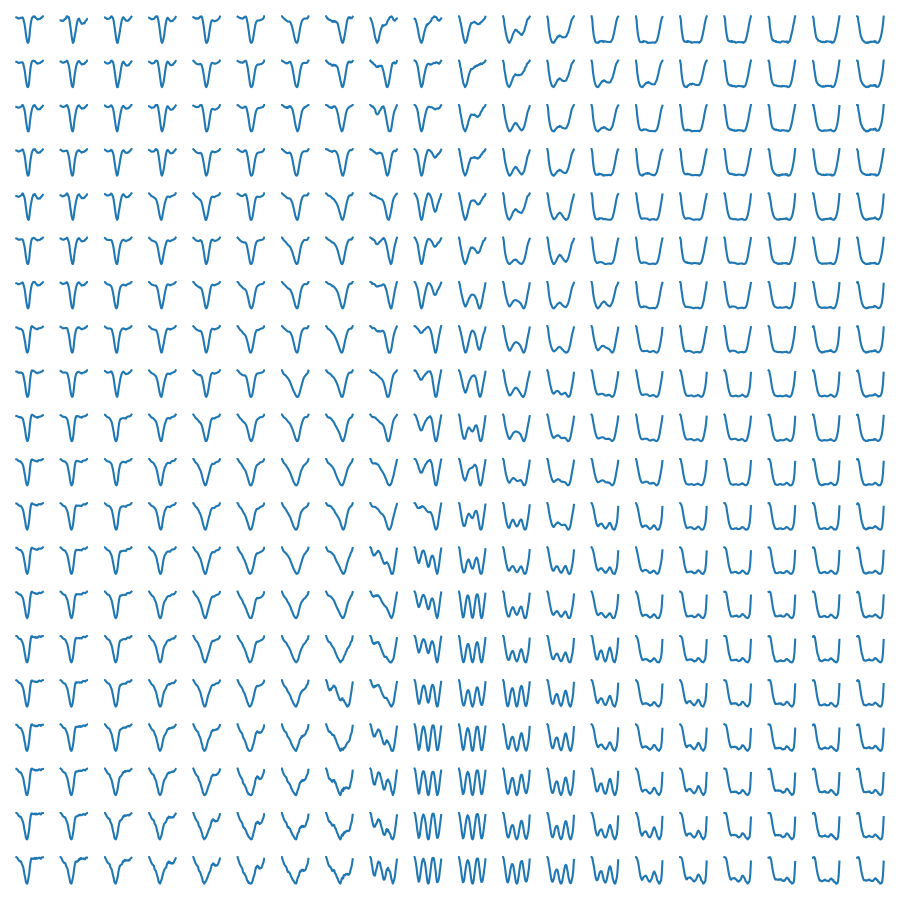

In [38]:
mu_ylims = [mu[:,0].min(), mu[:,0].max()]
mu_xlims = [mu[:,1].min(), mu[:,1].max()]
sigma_ylims = [sigma[:,0].min(), sigma[:,0].max()]
sigma_xlims = [sigma[:,1].min(), sigma[:,1].max()]

M = 20
mu_xlin = np.linspace(mu_xlims[0], mu_xlims[1], M)
mu_ylin = np.linspace(mu_ylims[1], mu_ylims[0], M)
sigma_xlin = np.linspace(sigma_xlims[0], sigma_xlims[1], M)
sigma_ylin = np.linspace(sigma_ylims[1], sigma_ylims[0], M)

fig, ax = plt.subplots(M, M, figsize=(9, 9), tight_layout=True)

for i in range(M):
    for j in range(M):
        ax[i, j].axis('off')
        z = torch.tensor([mu_ylin[i], mu_xlin[j]]) + torch.tensor([sigma_ylin[i], sigma_xlin[j]]).exp() * torch.normal(mean=torch.tensor([0., 0.]), std=torch.tensor([1.0, 1.0]))
        ax[i, j].invert_yaxis()
        ax[i, j].plot(model.decoder(z.float()).detach().numpy()[:40])

##### Las RR Lyrae se encuentran en el cuadrante 2 (arriba a la izquiera). Tambien parecen haber un poco mas abajo de la coordenada 7,7. Lo que es seguro es que es la mitad izquierda.

<IPython.core.display.Javascript object>


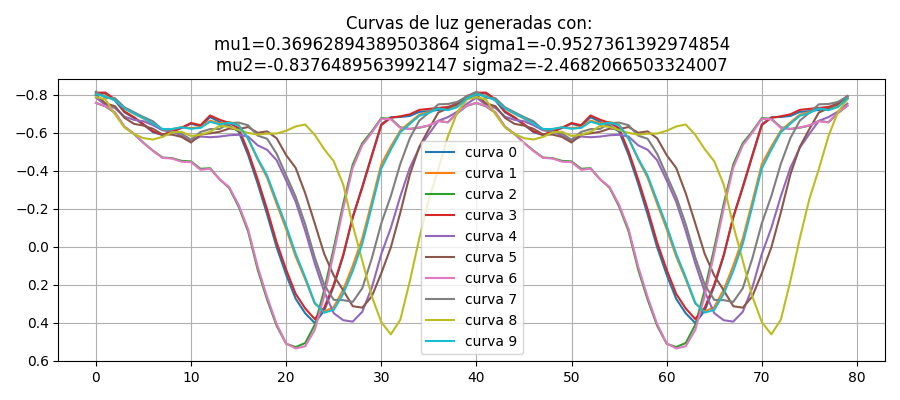

In [51]:
fig, ax = plt.subplots(tight_layout=True, figsize=(9,4))
ax.invert_yaxis()
ax.grid()
ax.title.set_text("Curvas de luz generadas con: \nmu1="+str(mu_ylin[7]) + " sigma1=" + str(sigma_ylin[7]) +"\nmu2="+str(mu_xlin[6]) + " sigma2=" + str(sigma_xlin[6]))

for i in range(10):
    z = torch.tensor([mu_ylin[7], mu_xlin[6]]) + torch.tensor([sigma_ylin[7], sigma_xlin[6]]).exp() * torch.normal(mean=torch.tensor([0., 0.]), std=torch.tensor([1.0, 1.0]))
    res = model.decoder((z.float())).detach().numpy()
    ax.plot(np.hstack((res[:40],res[:40])) , label="curva "+str(i))
ax.legend()


# Conclusion

##### En conclusion, las 2 formas parecen dar buenos resultados a la hora de reconstruir las curvas de luz.
##### Si se comparan los scatter plot de las curvas de luz en el espacio latente de ambos metodos, se puede ver un resultado similar. Pareciera ser, a simple vista, que el segundo metodo tiene barras de error mas grandes por curva (represetando la incerteza del modelo (?) ), lo que no necesariamente es un hecho negativo. 
##### La distribucion de los puntos en el primer caso es muy similar a una gaussiana en 2d, mientras que el en segundo metodo, tambien parece tener este comportamiento pero con zonas mucho mas densas.
##### Un hecho que me parecio interesante, es que las 10 curvas de luz generadas por el segundo metodo testan fuera de fase unas con otras, pero todas parecen ser RR Lyrae, mientras que en el primer metodo, las 10 curvas estan en fase, con pequenas diferencias en magnitud. Imagino que este comportamiento se debe a las capas convolucionales, porq fueron capaces de obtener las curvaturas y otras propiedades independientes de donde estuvieran en la curva.  